In [2]:
from torchvision.transforms import Resize
from utils import *
from models.latentdiscovery.utils import load_generator
from torchvision.utils import save_image
import numpy as np
import random
import torch.nn.functional as F
from torchvision.models import resnet18
import torch.nn as nn
import matplotlib.pylab as plt
import torchvision
from IPython import display
%matplotlib inline

StyleGAN2 load fail: No module named 'StyleGAN2'


In [3]:
def set_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)

## Configurations

In [4]:
random_seed = 1234
set_seed(random_seed)
load_codes = True
algo = 'ortho'
root_dir= '/home/adarsh/PycharmProjects/disentagled_latent_dirs'
result_path = os.path.join(root_dir,  'results/celeba_hq/latent_discovery/qualitative_analysis')

## Model Selection

In [5]:
deformator_path = os.path.join(root_dir, 'pretrained_models/deformators/LatentDiscovery/pggan_celebahq1024/deformator_0.pt')
cf_deformator_ = torch.load(deformator_path, map_location='cpu')
cf_deformator = torch.FloatTensor(cf_deformator_['linear.weight'][:,:200]).cuda().T
cf_bias = torch.FloatTensor(cf_deformator_['linear.bias']).cuda().T


deformator_path = os.path.join(root_dir, 'results/celeba_hq/latent_discovery_ours/models/20000_model.pkl')
algo == 'ortho'
if algo == 'ortho':
    deformator = torch.load(deformator_path)['deformator']['ortho_mat'][:,:200].cuda()
    dse_deformator = deformator.T
elif algo == 'linear':
    deformator = torch.load(os.path.join(deformator_path),map_location='cpu')['deformator']
    dse_deformator = torch.FloatTensor(deformator['linear.weight'][:,:200]).cuda().T
    dse_bias = torch.FloatTensor(deformator['linear.bias']).cuda().T
        
generator = load_generator(None, model_name='pggan_celebahq1024', gan_type = 'ProgGAN')
generator.eval().cuda()

# if load_codes:
#     codes = np.load(os.path.join(root_dir, 'pretrained_models/latent_codes/pggan_celebahq1024_latents.npy'))
#     codes = torch.from_numpy(codes).type(torch.FloatTensor).cuda()
#     codes = torch.load(os.path.join(root_dir, 'results/celeba_hq/closed_form_ours/quantitative_analysis/z_analysis.pkl'))
# else:
num_samples = 1000
codes = torch.randn(num_samples,512,1,1).cuda()

#  Plot only one deformator latent traversal

In [ ]:
def postprocess_images(images):
        """Post-processes images from `torch.Tensor` to `numpy.ndarray`."""
        images = images.detach().cpu().numpy()
        images = (images + 1) * 255 / 2
        images = np.clip(images + 0.5, 0, 255).astype(np.uint8)
        images = images.transpose(0, 2, 3, 1)
        return images


def save_images(codes, bias, shifts_r, shifts_count, cf_dir,generator, cf_deformator):
        plt.figure(figsize=(30,30))
        for idx, z in enumerate(codes):
            print('Figure : ' + str(idx))
            z_shift_cf = []
            for i, shift in enumerate(np.linspace(-shifts_r,shifts_r,shifts_count)):
                direction = cf_deformator[cf_dir: cf_dir + 1] 
                direction = direction.unsqueeze(2)
                direction = direction.unsqueeze(3)
                z_shifted = z.view(1,512,1,1) +  direction* shift + bias.view(-1,512,1,1)
                z_shift_cf.append(z_shifted)
            z_shift_cf = torch.stack(z_shift_cf)
            z_shift_cf = z_shift_cf.squeeze(1)
            with torch.no_grad():
                cf_images= generator(z_shift_cf)
            temp_path = os.path.join(result_path, 'temp')
            os.makedirs(temp_path, exist_ok = True)
            torch.save(cf_images, os.path.join(temp_path, 'cf.pkl'))
            del cf_images
            cf_images = torch.load(os.path.join(temp_path, 'cf.pkl'))
            all_images = cf_images
            grid = torchvision.utils.make_grid(all_images.clamp(min=-1, max=1),nrow=10, scale_each=True, normalize=True)
            display.display(plt.gcf())
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            del all_images
            del cf_images
            del grid

    
z_min_index = 0
z_max_index = 10
cf_dir = 190
shift_r = 10
shift_count = 10
all_images = save_images(codes[z_min_index:z_max_index],cf_bias, shift_r, shift_count, cf_dir, generator, cf_deformator)                    

# Plot comparison for both deformators

Figure : 0


<Figure size 2160x2160 with 0 Axes>

Figure : 1


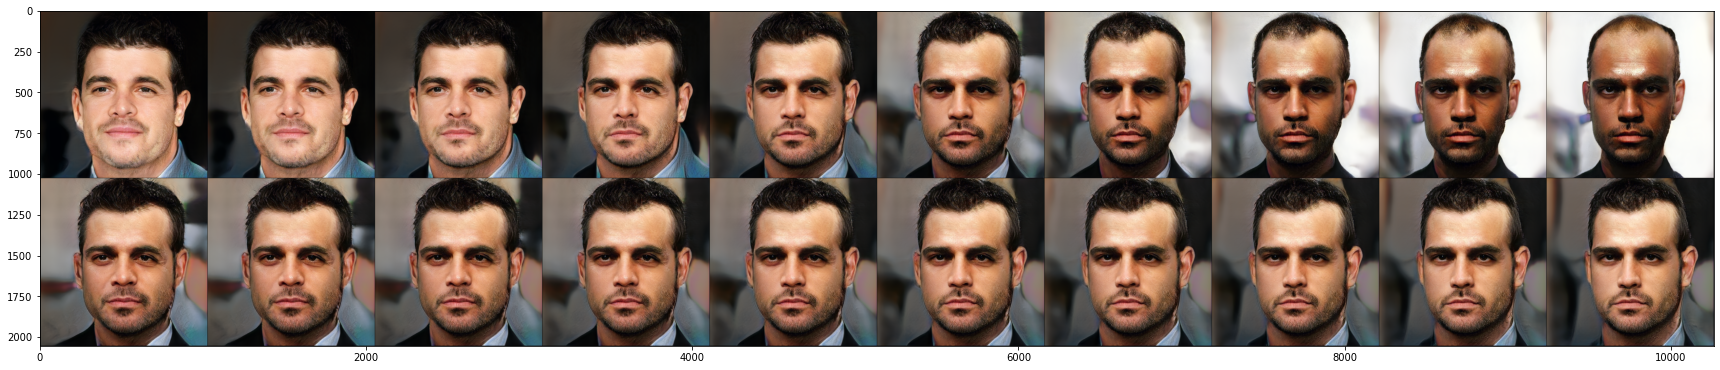

Figure : 2


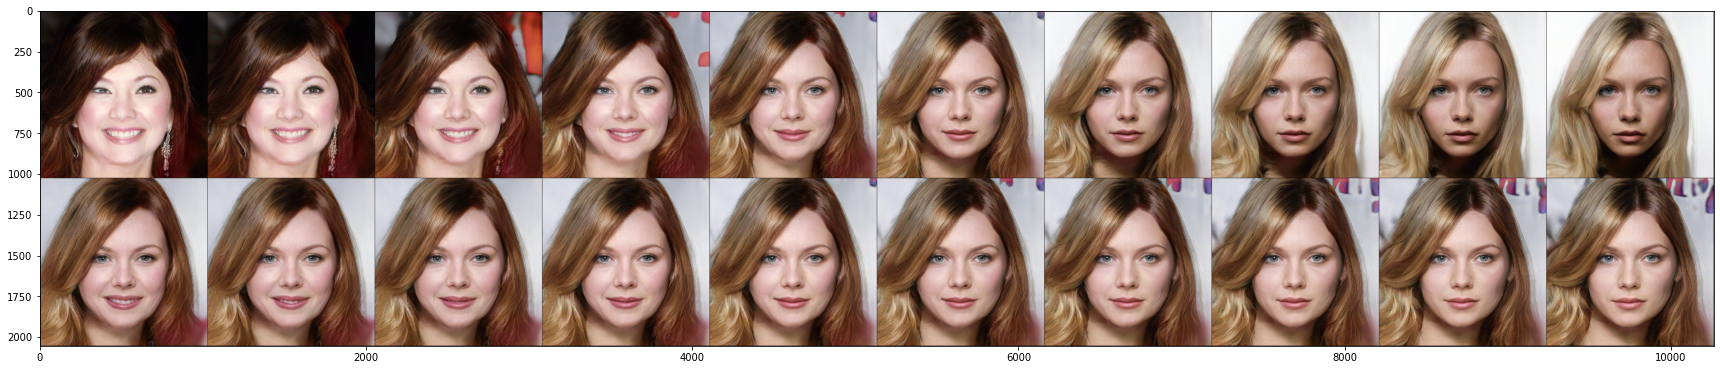

Figure : 3


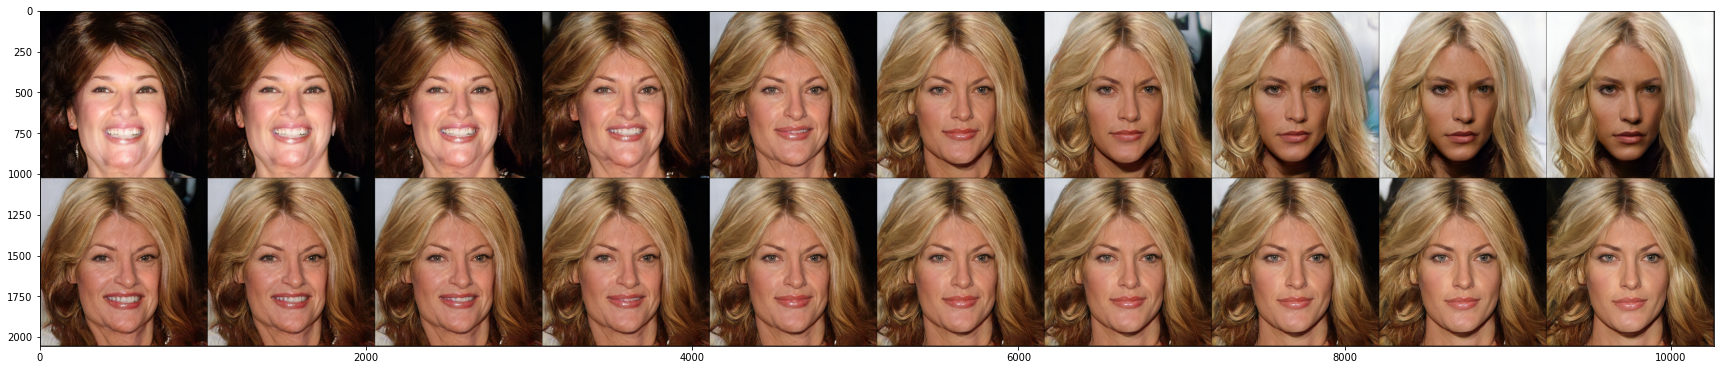

Figure : 4


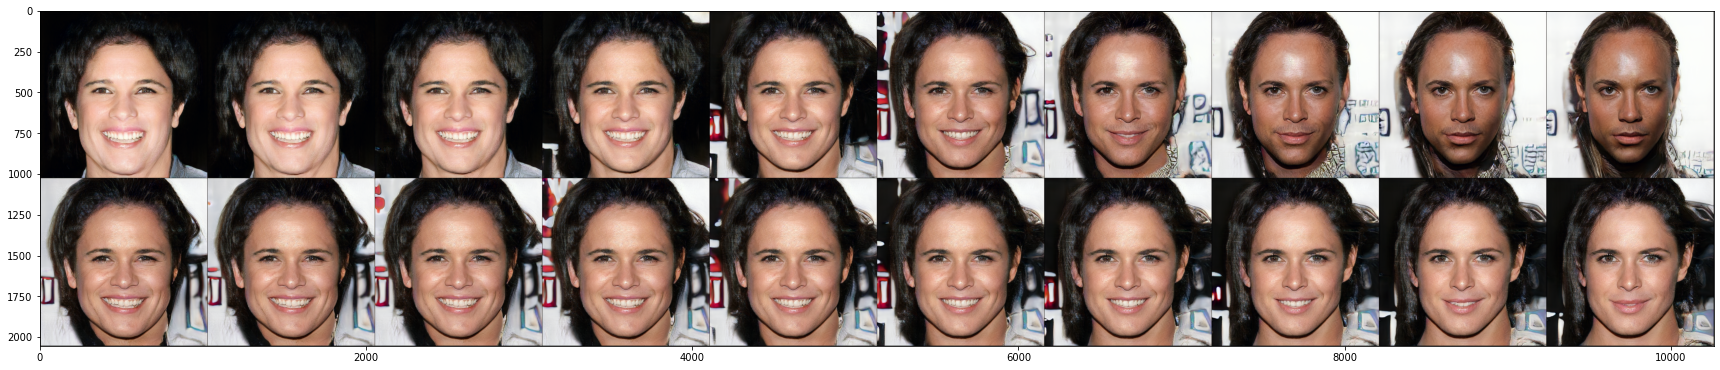

Figure : 5


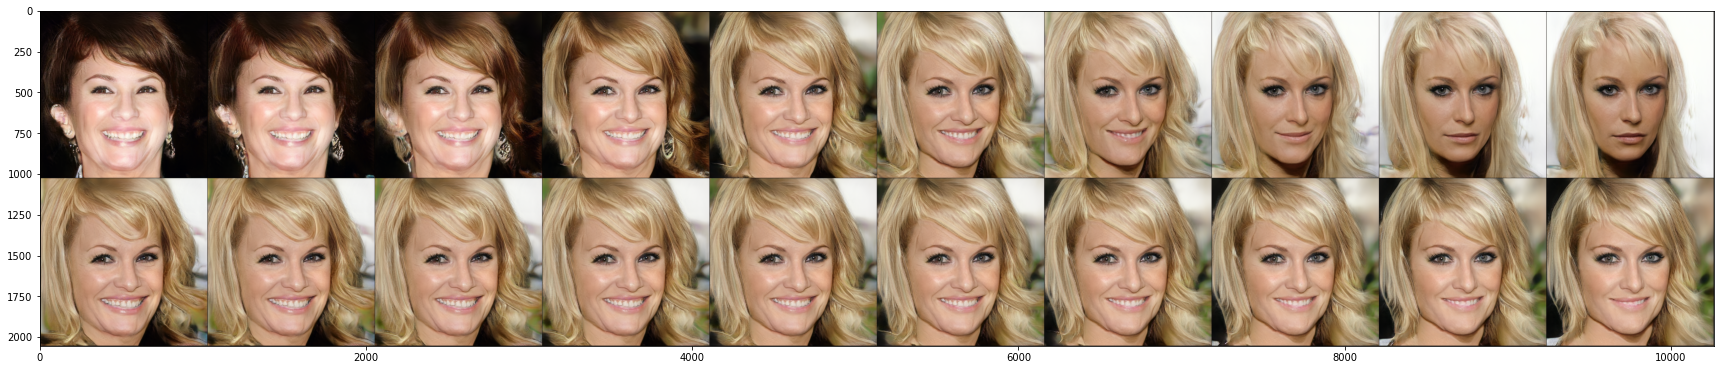

Figure : 6


In [ ]:
def postprocess_images(images):
        """Post-processes images from `torch.Tensor` to `numpy.ndarray`."""
        images = images.detach().cpu().numpy()
        images = (images + 1) * 255 / 2
        images = np.clip(images + 0.5, 0, 255).astype(np.uint8)
        images = images.transpose(0, 2, 3, 1)
        return images


def save_images(codes, shifts_r, shifts_count, cf_dir, cf_bias, dse_dir, dse_bias, generator, cf_deformator, dse_deformator):
        plt.figure(figsize=(30,30))
        for idx, z in enumerate(codes):
            print('Figure : ' + str(idx))
            z_shift_cf = []
            z_shift_dse = []
            for i, shift in enumerate(np.linspace(-shifts_r,shifts_r,shifts_count)):
                direction = cf_deformator[cf_dir: cf_dir + 1] 
                direction = direction.unsqueeze(2)
                direction = direction.unsqueeze(3)
                shifted_dir = direction* shift + cf_bias.view(1,512,1,1)
#                direction = (shift / torch.norm(shifted_dir, dim=1, keepdim=True)) * shifted_dir

                z_shifted = z.view(1,512,1,1) +  shifted_dir
                z_shift_cf.append(z_shifted)
                
                direction = dse_deformator[dse_dir: dse_dir + 1] 
                direction = direction.unsqueeze(2)
                direction = direction.unsqueeze(3)
                shifted_dir = direction * shift + dse_bias.view(1,512,1,1)
#                direction = (shift / torch.norm(shifted_dir, dim=1, keepdim=True)) * shifted_dir
                z_shifted = z.view(1,512,1,1) +  shifted_dir
                z_shift_dse.append(z_shifted)
                
            
            z_shift_cf = torch.stack(z_shift_cf).squeeze(dim=1)
            z_shift_dse = torch.stack(z_shift_dse).squeeze(dim=1)
            with torch.no_grad():
                cf_images= generator(z_shift_cf)
            torch.save(cf_images, os.path.join(result_path, 'temp', 'cf.pkl'))
            del cf_images
            with torch.no_grad():
                dse_images= generator(z_shift_dse)
            torch.save(dse_images, os.path.join(result_path, 'temp', 'dse.pkl'))
            del dse_images
            cf_images = torch.load(os.path.join(result_path, 'temp', 'cf.pkl'))
            dse_images = torch.load(os.path.join(result_path, 'temp', 'dse.pkl'))
            all_images = torch.cat((cf_images, dse_images), dim=0)
            grid = torchvision.utils.make_grid(all_images.clamp(min=-1, max=1),nrow=10, scale_each=True, normalize=True)
            display.display(plt.gcf())
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            del all_images
            del cf_images
            del dse_images
            del grid

    
z_min_index = 10
z_max_index = 20
cf_dir = 189
dse_dir = 189
shift_r = 10
shift_count = 10
# cf_bias = torch.zeros(1,512,1,1).cuda()
dse_bias = torch.zeros(1,512,1,1).cuda()
all_images = save_images(codes[z_min_index:z_max_index], shift_r, shift_count, cf_dir, cf_bias, dse_dir,dse_bias, generator, cf_deformator, dse_deformator)                    